# 잡음제거 오토인코더 모델

## 메모리를 아끼는 데이터 로드

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [5]:
# DATA_PATH
ORG_DATA_PATH = './Dataset/Original/'
NIS_DATA_PATH = './Dataset/Noisy/'
filepaths = os.listdir(ORG_DATA_PATH)

In [7]:
class Dataset(tf.keras.utils.Sequence):
    def __init__(self,
               org_path,
               nis_path,
               filepaths,
               target_size=(256,256),
               batch_size=32,
               suffle=True
               ):
        self.org_path = org_path
        self.nis_path = nis_path
        self.target_size = target_size
        self.filepaths = filepaths
        self.batch_size = batch_size
        if suffle:
            np.random.shuffle(self.filepaths)

    def __getitem__(self, index):
        low = index * self.batch_size
        high = min(low+self.batch_size, len(self.filepaths))

        self.x = []
        self.y = []
        for p in self.filepaths[low:high]:
            # load
            org_img = cv2.imread(os.path.join(self.org_path, p))
            nis_img = cv2.imread(os.path.join(self.nis_path, p))
            # resize
            org_img = cv2.resize(org_img, dsize=self.target_size)
            nis_img = cv2.resize(nis_img, dsize=self.target_size)
            # scaling
            org_img = np.divide(org_img, 255.)
            nis_img = np.divide(nis_img, 255.)
            
            self.x.append(nis_img)
            self.y.append(org_img)

        return np.array(self.x), np.array(self.y)

    def __len__(self):
        return int(np.ceil(len(self.filepaths) // self.batch_size))

In [8]:
# 설계한 대로 데이터셋 선언
dataset = Dataset(org_path=ORG_DATA_PATH,
                 nis_path=NIS_DATA_PATH,
                 filepaths=filepaths)

In [9]:
# 올바르게 로드하는지 테스트
x, y = next(iter(dataset))

In [39]:
for x, y in dataset:
    print(x.shape, y.shape)

(32, 256, 256, 3) (32, 256, 256, 3)
(32, 256, 256, 3) (32, 256, 256, 3)
(32, 256, 256, 3) (32, 256, 256, 3)
(32, 256, 256, 3) (32, 256, 256, 3)
(32, 256, 256, 3) (32, 256, 256, 3)
(32, 256, 256, 3) (32, 256, 256, 3)
(32, 256, 256, 3) (32, 256, 256, 3)
(32, 256, 256, 3) (32, 256, 256, 3)
(32, 256, 256, 3) (32, 256, 256, 3)
(32, 256, 256, 3) (32, 256, 256, 3)
(32, 256, 256, 3) (32, 256, 256, 3)
(32, 256, 256, 3) (32, 256, 256, 3)
(32, 256, 256, 3) (32, 256, 256, 3)
(32, 256, 256, 3) (32, 256, 256, 3)
(32, 256, 256, 3) (32, 256, 256, 3)
(32, 256, 256, 3) (32, 256, 256, 3)
(32, 256, 256, 3) (32, 256, 256, 3)
(32, 256, 256, 3) (32, 256, 256, 3)
(32, 256, 256, 3) (32, 256, 256, 3)
(32, 256, 256, 3) (32, 256, 256, 3)
(32, 256, 256, 3) (32, 256, 256, 3)
(32, 256, 256, 3) (32, 256, 256, 3)
(32, 256, 256, 3) (32, 256, 256, 3)
(32, 256, 256, 3) (32, 256, 256, 3)
(32, 256, 256, 3) (32, 256, 256, 3)
(32, 256, 256, 3) (32, 256, 256, 3)
(32, 256, 256, 3) (32, 256, 256, 3)
(32, 256, 256, 3) (32, 256, 

(-0.5, 255.5, 255.5, -0.5)

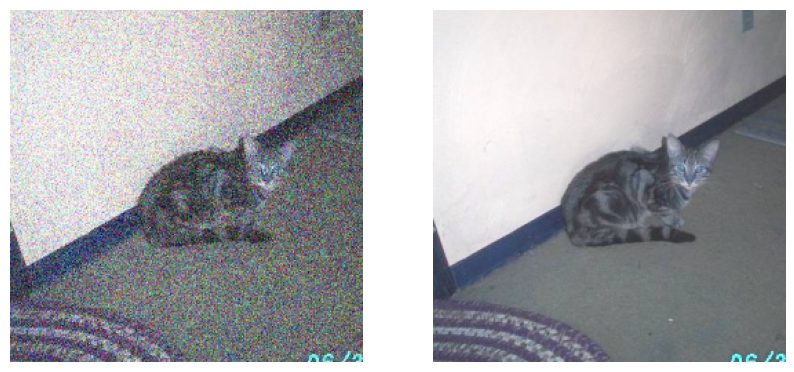

In [12]:
sample_x = x[0]
sample_y = y[0]
fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].imshow(sample_x)
axes[1].imshow(sample_y)
axes[0].axis('off')
axes[1].axis('off')

In [13]:
# Sequence 방법과 일반 방법의 비교
'''
x = []
y = []
for p in filepaths:
    # load
    org_img = cv2.imread(os.path.join(ORG_DATA_PATH, p))
    nis_img = cv2.imread(os.path.join(NIS_DATA_PATH, p))
    # resize
    org_img = cv2.resize(org_img, dsize=(256,256))
    nis_img = cv2.resize(nis_img, dsize=(256,256))
    # scaling
    org_img = np.divide(org_img, 255.)
    nis_img = np.divide(nis_img, 255.)

    x.append(nis_img)
    y.append(org_img)
'''

'\nx = []\ny = []\nfor p in filepaths:\n    # load\n    org_img = cv2.imread(os.path.join(ORG_DATA_PATH, p))\n    nis_img = cv2.imread(os.path.join(NIS_DATA_PATH, p))\n    # resize\n    org_img = cv2.resize(org_img, dsize=(256,256))\n    nis_img = cv2.resize(nis_img, dsize=(256,256))\n    # scaling\n    org_img = np.divide(org_img, 255.)\n    nis_img = np.divide(nis_img, 255.)\n\n    x.append(nis_img)\n    y.append(org_img)\n'

## 데이터셋 분리 (Split)

In [121]:
from sklearn.model_selection import train_test_split

# 전체 파일 경로를 훈련 데이터와 검증 데이터로 분리
train_filepaths, val_filepaths = train_test_split(filepaths, test_size=0.1, random_state=42)

In [136]:
print(len(train_filepaths), len(val_filepaths))

900 100


In [122]:
# 훈련 데이터셋과 검증 데이터셋을 만듭니다.
train_dataset = Dataset(org_path=ORG_DATA_PATH,
                        nis_path=NIS_DATA_PATH,
                        filepaths=train_filepaths)

val_dataset = Dataset(org_path=ORG_DATA_PATH,
                      nis_path=NIS_DATA_PATH,
                      filepaths=val_filepaths)

## 마들링

In [15]:
from tensorflow.keras import layers, models, optimizers, utils, datasets

In [133]:
input_layer = layers.Input(shape=(256, 256, 3))

# Encoder
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

model = models.Model(input_layer, decoded)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_18 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_19 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_20 (Conv2D)          (None, 64, 64, 32)        9248

In [134]:
model.compile(loss='mae', optimizer='adam')  # metrics 추가

In [135]:
model.fit(train_dataset, epochs=20, validation_data=val_dataset)

Epoch 1/20
28/28 [==============================] - 6s 182ms/step - loss: 0.1660 - val_loss: 0.0961
Epoch 2/20
28/28 [==============================] - 5s 176ms/step - loss: 0.0791 - val_loss: 0.0638
Epoch 3/20
28/28 [==============================] - 5s 178ms/step - loss: 0.0635 - val_loss: 0.0544
Epoch 4/20
28/28 [==============================] - 5s 176ms/step - loss: 0.0547 - val_loss: 0.0473
Epoch 5/20
28/28 [==============================] - 5s 179ms/step - loss: 0.0506 - val_loss: 0.0450
Epoch 6/20
28/28 [==============================] - 5s 179ms/step - loss: 0.0481 - val_loss: 0.0428
Epoch 7/20
28/28 [==============================] - 5s 180ms/step - loss: 0.0477 - val_loss: 0.0456
Epoch 8/20
28/28 [==============================] - 5s 179ms/step - loss: 0.0443 - val_loss: 0.0398
Epoch 9/20
28/28 [==============================] - 5s 182ms/step - loss: 0.0429 - val_loss: 0.0452
Epoch 10/20
28/28 [==============================] - 5s 179ms/step - loss: 0.0411 - val_loss: 0.0401

(-0.5, 498.5, 390.5, -0.5)

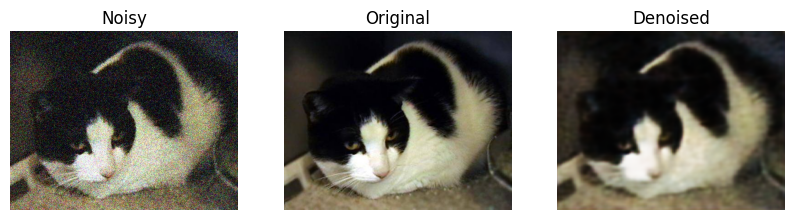

In [155]:
from functools import partial
# predict
rnd_idx = np.random.randint(0, len(filepaths), 1)[0]
noisy_smp = cv2.imread(os.path.join(NIS_DATA_PATH, filepaths[rnd_idx]))
org_smp = cv2.imread(os.path.join(ORG_DATA_PATH, filepaths[rnd_idx]))

input_img = cv2.resize(noisy_smp, (256,256))
input_img = np.divide(input_img, 255.)

denoised_img = model.predict(input_img[np.newaxis,...])
denoised_img = (denoised_img[0]*255.).astype(np.uint8)
denoised_img = cv2.resize(denoised_img, org_smp.shape[1::-1])

bgr2rgb = partial(cv2.cvtColor, code=cv2.COLOR_BGR2RGB)


# compare results
fig, axes = plt.subplots(1,3,figsize=(10,5))
axes[0].imshow(bgr2rgb(noisy_smp))
axes[1].imshow(bgr2rgb(org_smp))
axes[2].imshow(bgr2rgb(denoised_img))
axes[0].set_title('Noisy'); axes[0].axis('off')
axes[1].set_title('Original'); axes[1].axis('off')
axes[2].set_title('Denoised'); axes[2].axis('off')